In [1]:
# Import libraries and dependencies
import os
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import random


In [2]:
# Load the environment variables by calling the load_dotenv function
load_dotenv()

True

In [3]:
# Set Alpaca API key and secret by calling the os.getenv function and referencing the environment variable names
# Set each environment variable to a notebook variable of the same name
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

# Check the values were imported correctly by evaluating the type of each.
display(type(alpaca_api_key))
display(type(alpaca_secret_key))

str

str

In [4]:
# Create your Alpaca API REST object by calling Alpaca's tradeapi.REST function.
# Set the parameters to your alpaca_api_key, alpaca_secret_key and api_version="v2" 
alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2")

In [5]:
# Gather portfolio preferences from user

risk_score = input("""What's your risk score? Rate from 0 - 10 with 10 being the highest risk preference for the portfolio.
""")

preference_equity = input("""What's your investment strategy preference for equity? 
Type 1 for Dividend Income
Type 2 for Capital Growth
Type 3 for Balanced
""")


preference_fixed_income = input("""What's your investment strategy preference for fixed income?
Type 1 for Higher Risk
Type 2 for Higher Quality
Type 3 for Mixed
""")


time_period = input("""What's your preferred time duration for investment? Enter a number to indicate the number of years.
""")


investment_value = input("""What is the value of your initial investment? Enter a numerical value to indicate the starting dollar amount.
""")

risk_score = int(risk_score)
preference_equity = int(preference_equity)
preference_fixed_income = int(preference_fixed_income)
time_period = int(time_period)
investment_value = int(investment_value)

What's your risk score? Rate from 0 - 10 with 10 being the highest risk preference for the portfolio.
 7
What's your investment strategy preference for equity? 
Type 1 for Dividend Income
Type 2 for Capital Growth
Type 3 for Balanced
 1
What's your investment strategy preference for fixed income?
Type 1 for Higher Risk
Type 2 for Higher Quality
Type 3 for Mixed
 2
What's your preferred time duration for investment? Enter a number to indicate the number of years.
 5
What is the value of your initial investment? Enter a numerical value to indicate the starting dollar amount.
 30000


In [6]:
# Create the list for the required tickers

# equity
tickers_equity_type1 = ["DIA", "DVY", "VNQ"]#dividend income
tickers_equity_type2 = ["QQQ", "VBK", "ARKK"]#capital growth
tickers_equity_type3 = ["SPY", "VXF", "IWM"]#balanced

# income
tickers_income_type1 = ["LQD"]#higher risk
tickers_income_type2 = ["IEI"]#higher quality
tickers_income_type3 = ["AGG"]#mixed

In [7]:
# Risk score needs to be converted to asset weights

weight_risk = risk_score/10 
weight_fixed = 1 - weight_risk 

        
    
# Do we need the below code???????

# equity_investment = investment_value * weight_risk ($700)
# DIA = (1/3)* equity_investment
# DVY = (1/3)* equity_investment
# VNQ = (1/3)* equity_investment


# income_investment = investment_value * weight_fixed ($300)

In [8]:
# Assigns an empty list for tickers to be used for equity. If statement from user input determines how list is populated.

equity_tickers = []

if preference_equity == 1:
    equity_tickers = tickers_equity_type1
    
elif preference_equity == 2:
    equity_tickers = tickers_equity_type2
    
elif preference_equity == 3:
    equity_tickers = tickers_equity_type3

else:
    print("You did not enter a valid equity preference. Please try again.")

In [9]:
# Assigns an empty list for tickers to be used for fixed income. If statement from user input determines how list is populated.

fixed_income_tickers = []

if preference_fixed_income == 1:
    fixed_income_tickers = tickers_income_type1
    
elif preference_fixed_income == 2:
    fixed_income_tickers = tickers_income_type2
    
elif preference_fixed_income == 3:
    fixed_income_tickers = tickers_income_type3

else:
    print("You did not enter a valid equity preference. Please try again.")

In [10]:
tickers = equity_tickers + fixed_income_tickers
tickers

['DIA', 'DVY', 'VNQ', 'IEI']

In [11]:
# Determines weights to be applied to each ETF in the portfolio. For this analysis, assumes equity ETFs will be equal weighted.

weight_equity_1 = weight_risk / 3
weight_equity_2 = weight_risk /3
weight_equity_3 = weight_risk / 3
weight_fixed = 1 - weight_equity_1 - weight_equity_2 - weight_equity_3

weights = [weight_equity_1, weight_equity_2, weight_equity_3, weight_fixed]
weights

[0.2333333333333333,
 0.2333333333333333,
 0.2333333333333333,
 0.30000000000000016]

In [12]:
# Places portfolio tickers and weights into a dataframe and sorts alphabetically in order to run API call for ticker data

portfolio_df = pd.DataFrame({'tickers': tickers, 'weights': weights})
portfolio_df = portfolio_df.sort_values('tickers')
portfolio_df

,tickers,weights
0,DIA,0.233333
1,DVY,0.233333
3,IEI,0.300000
2,VNQ,0.233333


In [13]:
# recreates tickers list, this time in alphabetical order
tickers = portfolio_df['tickers'].tolist()
tickers

['DIA', 'DVY', 'IEI', 'VNQ']

In [14]:
# recreates weights list, this time, in the same order as the new sorted tickers list
weights = portfolio_df['weights'].tolist()
weights

[0.2333333333333333,
 0.2333333333333333,
 0.30000000000000016,
 0.2333333333333333]

In [15]:
# sets number of trading days for the simulation (time horizon of the investment)
num_trading_days = 252 * time_period

In [16]:
# Set the values for start_date and end_date using the pd.Timestamp function
# Inside the function set the date parameter to the prior business day 
# The start and end data should be 2017-05-01 to 2020-05-01
# Set the parameter tz to "America/New_York", 
# Set this all to the ISO format by calling the isoformat function 
start_date = pd.Timestamp("2018-12-31", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-12-31", tz="America/New_York").isoformat()

In [17]:
# Set timeframe to one day (1D)
timeframe = "1D"

# Set number of rows to 1000 to retrieve the maximum amount of rows
limit_rows = 1000

In [18]:
# Use the Alpaca get_barset function to gather the price information for each ticker
# Include the function parameters: tickers, timeframe, start, end, and limit
# Be sure to call the df property to ensure that the returned information is set as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start=start_date,
    end=end_date,
    limit=limit_rows
).df

# Review the first five rows of the resulting DataFrame 
prices_df.head()

DIA                                        DVY  \
                             open    high      low     close   volume   open   
time                                                                           
2018-12-31 00:00:00-05:00  232.33  233.22  231.050  231.7700  4600042  89.06   
2019-01-02 00:00:00-05:00  229.27  234.00  229.140  232.9800  4949729  88.29   
2019-01-03 00:00:00-05:00  231.25  231.42  226.621  227.1900  6864028  88.80   
2019-01-04 00:00:00-05:00  230.00  235.18  229.730  234.2401  6976907  88.83   
2019-01-07 00:00:00-05:00  234.84  236.88  232.951  235.3900  3873356  90.41   

                                                                   IEI  \
                              high      low   close     volume    open   
time                                                                     
2018-12-31 00:00:00-05:00  89.3099  88.3000  88.950  2673934.0  121.14   
2019-01-02 00:00:00-05:00  89.3300  87.8700  88.970  1164455.0  121.52   
2019-01-03 00:00:00-05:00  89.1800  87.9100  88.280   995745.0  121.62   
2019-01-04 00:00:00-05:00  90.4499  88.4201  90.350  1590662.0  121.70   
2019-01-07 00:00:00-05:00  91.5600  89.9500  90.905  1899922.0  121.67   

                                                                 VNQ           \
                             high       low    close   volume   open     high   
time                                                                            
2018-12-31 00:00:00-05:00  121.51  121.0900  121.455  1515989  74.31  74.7200   
2019-01-02 00:00:00-05:00  121.56  121.4100  121.560  1303584  73.56  73.7000   
2019-01-03 00:00:00-05:00  122.29  121.6000  122.240   562954  72.77  74.5700   
2019-01-04 00:00:00-05:00  121.74  121.5200  121.575   616288  73.74  75.0200   
2019-01-07 00:00:00-05:00  121.72  121.3233  121.335   749787  74.60  75.6062   

                                                    
                             low   close    volume  
time                                                
2018-12-31 00:00:00-05:00  73.30  74.405  15320211  
2019-01-02 00:00:00-05:00  72.53  72.880  10872410  
2019-01-03 00:00:00-05:00  72.71  73.430   9963138  
2019-01-04 00:00:00-05:00  73.30  74.330   7585079  
2019-01-07 00:00:00-05:00  74.40  75.045   7502420

In [19]:
# Configure a Monte Carlo simulation to forecast five years cumulative returns
# Use an even weight of .33 across all 3 stocks
MC_even_weight = MCSimulation(
    portfolio_data = prices_df,
    weights = weights,
    num_simulation = 500,
    num_trading_days = num_trading_days
)

# Printing the first five rows of the simulation input data
MC_even_weight.portfolio_data.head()

DIA                                      \
                             open    high      low     close   volume   
time                                                                    
2018-12-31 00:00:00-05:00  232.33  233.22  231.050  231.7700  4600042   
2019-01-02 00:00:00-05:00  229.27  234.00  229.140  232.9800  4949729   
2019-01-03 00:00:00-05:00  231.25  231.42  226.621  227.1900  6864028   
2019-01-04 00:00:00-05:00  230.00  235.18  229.730  234.2401  6976907   
2019-01-07 00:00:00-05:00  234.84  236.88  232.951  235.3900  3873356   

                                          DVY                            ...  \
                          daily_return   open     high      low   close  ...   
time                                                                     ...   
2018-12-31 00:00:00-05:00          NaN  89.06  89.3099  88.3000  88.950  ...   
2019-01-02 00:00:00-05:00     0.005221  88.29  89.3300  87.8700  88.970  ...   
2019-01-03 00:00:00-05:00    -0.024852  88.80  89.1800  87.9100  88.280  ...   
2019-01-04 00:00:00-05:00     0.031032  88.83  90.4499  88.4201  90.350  ...   
2019-01-07 00:00:00-05:00     0.004909  90.41  91.5600  89.9500  90.905  ...   

                                IEI                                   VNQ  \
                                low    close   volume daily_return   open   
time                                                                        
2018-12-31 00:00:00-05:00  121.0900  121.455  1515989          NaN  74.31   
2019-01-02 00:00:00-05:00  121.4100  121.560  1303584     0.000865  73.56   
2019-01-03 00:00:00-05:00  121.6000  122.240   562954     0.005594  72.77   
2019-01-04 00:00:00-05:00  121.5200  121.575   616288    -0.005440  73.74   
2019-01-07 00:00:00-05:00  121.3233  121.335   749787    -0.001974  74.60   

                                                                          
                              high    low   close    volume daily_return  
time                                                                      
2018-12-31 00:00:00-05:00  74.7200  73.30  74.405  15320211          NaN  
2019-01-02 00:00:00-05:00  73.7000  72.53  72.880  10872410    -0.020496  
2019-01-03 00:00:00-05:00  74.5700  72.71  73.430   9963138     0.007547  
2019-01-04 00:00:00-05:00  75.0200  73.30  74.330   7585079     0.012257  
2019-01-07 00:00:00-05:00  75.6062  74.40  75.045   7502420     0.009619  

[5 rows x 24 columns]

In [20]:
# Run a Monte Carlo simulation to forecast five years cumulative returns
# Create a new variable for the simulation above
sim_df = MC_even_weight.calc_cumulative_return()
sim_df

C:\Users\mwoji\FinTech-Workspace\Projects\portfolio_optimizer\MCForecastTools.py:117: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  portfolio_cumulative_returns[n] = (1 + sim_df.fillna(0)).cumprod()


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000929,1.003498,1.001556,1.012908,0.983448,1.004234,0.984858,0.997475,1.006884,0.994558,...,1.011241,1.003124,0.999531,0.999858,1.008175,1.003220,0.992818,1.000826,0.999087,0.997321
2,0.997020,0.996114,0.994988,1.020324,0.980340,1.015606,0.991681,0.999262,1.011211,1.002810,...,1.008318,1.004470,1.007980,0.994991,1.005562,1.001382,0.981767,1.002462,0.991609,1.009273
3,0.995974,0.996583,0.999711,1.011400,0.988192,1.008156,1.003371,1.001020,1.007757,1.007814,...,1.013943,0.996883,1.005511,0.994766,1.008630,0.998409,0.987159,1.009864,0.995855,1.003559
4,0.996284,0.995409,0.994911,1.015346,0.993765,1.014484,1.003274,0.999598,1.019350,0.997767,...,1.012726,1.003353,0.998586,0.995870,0.998863,1.006096,0.970341,1.012296,0.995684,1.000784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.492342,1.296137,1.397914,2.400336,1.661867,2.168314,2.643569,2.310174,1.954351,1.739501,...,1.944647,1.947636,2.392274,1.501981,1.357221,1.892363,1.115153,1.928085,1.032565,1.339748
1257,1.487052,1.301649,1.393228,2.416837,1.666918,2.159094,2.650587,2.311018,1.977075,1.736092,...,1.952178,1.951256,2.409466,1.499908,1.358787,1.890164,1.110494,1.933446,1.027120,1.344950
1258,1.490227,1.308700,1.389124,2.427753,1.670364,2.145493,2.649804,2.313444,1.999452,1.722536,...,1.967923,1.961385,2.416050,1.494151,1.363659,1.899096,1.110434,1.928269,1.024722,1.333089
1259,1.494634,1.304691,1.383601,2.441633,1.667697,2.132387,2.619331,2.339801,1.991682,1.721751,...,1.963722,1.962836,2.433686,1.493042,1.363040,1.876350,1.109574,1.913154,1.035511,1.338190


In [21]:
# Computes and returns a dataframe for daily price returns of each simulation for each trading day
shift_df = sim_df.shift(-1)
returns_df = (shift_df - sim_df) / sim_df
returns_df

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0.000929,0.003498,0.001556,0.012908,-0.016552,0.004234,-0.015142,-0.002525,0.006884,-0.005442,...,0.011241,0.003124,-0.000469,-0.000142,0.008175,0.003220,-0.007182,0.000826,-0.000913,-0.002679
1,-0.003906,-0.007358,-0.006558,0.007321,-0.003160,0.011323,0.006928,0.001791,0.004297,0.008297,...,-0.002890,0.001341,0.008452,-0.004867,-0.002592,-0.001832,-0.011131,0.001634,-0.007484,0.011984
2,-0.001048,0.000471,0.004746,-0.008746,0.008010,-0.007335,0.011788,0.001760,-0.003415,0.004989,...,0.005579,-0.007553,-0.002449,-0.000227,0.003052,-0.002968,0.005492,0.007384,0.004281,-0.005661
3,0.000311,-0.001178,-0.004801,0.003901,0.005639,0.006277,-0.000096,-0.001421,0.011504,-0.009968,...,-0.001200,0.006490,-0.006887,0.001110,-0.009684,0.007699,-0.017037,0.002408,-0.000171,-0.002765
4,-0.009689,-0.007664,0.004738,0.003747,0.012576,-0.003620,0.006051,0.002840,0.006888,0.001506,...,0.002867,-0.005024,-0.000009,-0.007806,-0.003742,0.013360,-0.001368,0.004869,0.001262,0.002709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,-0.003544,0.004252,-0.003353,0.006874,0.003039,-0.004252,0.002655,0.000365,0.011627,-0.001960,...,0.003872,0.001859,0.007186,-0.001380,0.001154,-0.001162,-0.004179,0.002781,-0.005273,0.003882
1257,0.002135,0.005417,-0.002946,0.004517,0.002067,-0.006299,-0.000295,0.001050,0.011318,-0.007809,...,0.008065,0.005191,0.002733,-0.003838,0.003585,0.004726,-0.000054,-0.002678,-0.002334,-0.008819
1258,0.002957,-0.003064,-0.003976,0.005717,-0.001597,-0.006109,-0.011500,0.011393,-0.003886,-0.000456,...,-0.002135,0.000740,0.007299,-0.000743,-0.000453,-0.011977,-0.000774,-0.007838,0.010528,0.003826
1259,0.001772,-0.001855,0.000753,-0.000491,-0.007987,-0.001540,0.005367,-0.008428,0.001324,-0.000821,...,-0.003620,-0.004622,-0.000166,-0.004776,0.008889,0.006776,0.000207,-0.014124,-0.001712,0.005888


In [22]:
# Computes the standard deviation of returns for each simulation
annual_std_list = returns_df.std() * (252 **0.5)
annual_std_list

0      0.101261
1      0.104576
2      0.103904
3      0.103136
4      0.103953
         ...   
495    0.096942
496    0.103303
497    0.102304
498    0.098599
499    0.100819
Length: 500, dtype: float64

In [23]:
# and then averages the results to come up with an estimated standard deviation of the portfolio
annual_std = annual_std_list.mean()
annual_std

0.10202151877889021

In [24]:
# Repeats this process to come up with an annual return for each simulation
annual_ret_list = returns_df.mean() * 252
annual_ret_list

0      0.085863
1      0.058291
2      0.070492
3      0.183811
4      0.106103
         ...   
495    0.131942
496    0.026169
497    0.132164
498    0.011494
499    0.064525
Length: 500, dtype: float64

In [25]:
# and then averages the results to come up with an estimated return of the portfolio
annual_ret = annual_ret_list.mean()
annual_ret

0.12196411535466373

In [26]:
# Input for estimated income of the portfolio
annual_income = .02

In [27]:
#A function to simulate a random set of returns for a portfolio over a desired time horizon given various parameters
def simulate_return(mean_return, standard_dev, annual_income, simulated_quarters, number_of_simulations, initial_investment):
    
    #quarterly return of the portfolio plus quarterly income. the mean return could be a call to summary statistics and the annual income to a csv.
    quarterly_ret = (mean_return/4) + (annual_income/4)
    
    #quarterly standard deviation of the portfolio. standard deviation could be a call to summary statistics.
    quarterly_stdev = standard_dev / (4**0.5)
    
    #returns a random set of standard deviation multipliers plus the mean return. For example return +/- 1 SD or return +/- (1.65 x Std) to obtain a list of random returns
    quarterly_returns = 1 + np.random.normal(quarterly_ret, quarterly_stdev, (simulated_quarters,number_of_simulations))
    
    #defines the portfolio variable in the same array shape as the previously estimated returns
    portfolio = np.zeros_like(quarterly_returns)
    
    #sets an initial investment for the simulation
    portfolio[0] = initial_investment
    
    #for loop to project out portfolio market value for each simulation
    for t in range (1, simulated_quarters):
        portfolio[t] = (portfolio[t-1]*quarterly_returns[t])
    return pd.DataFrame(portfolio)

In [28]:
simulated_quarters = time_period * 4

<AxesSubplot:>

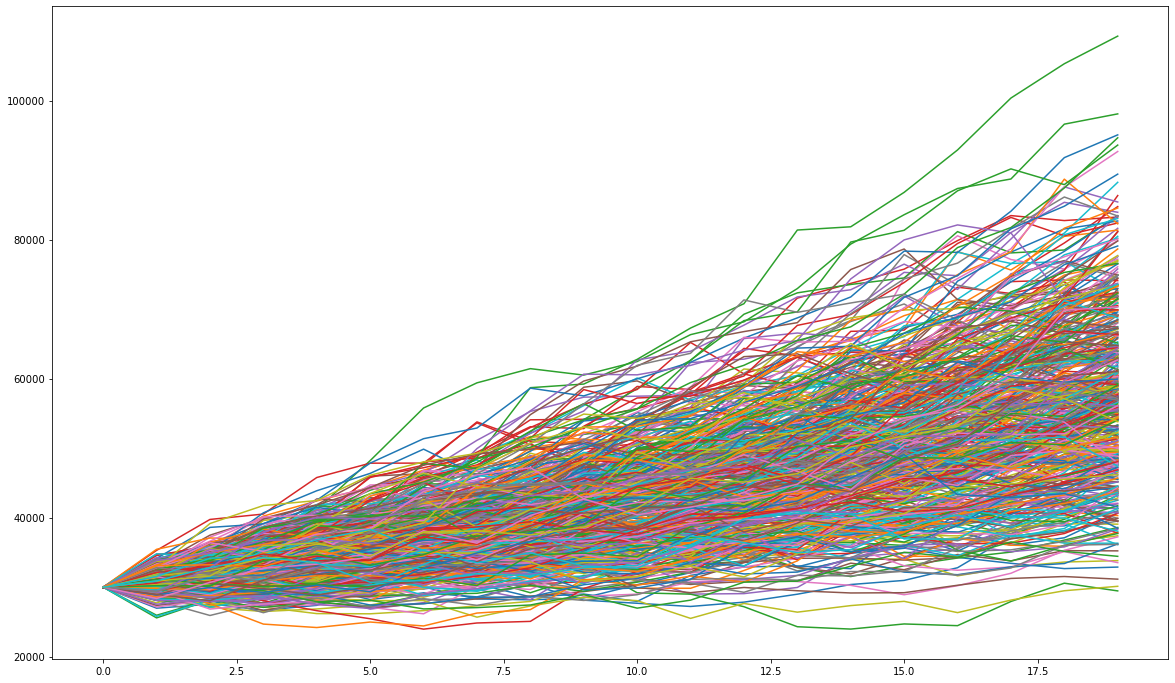

In [29]:
#plot the results. Ideally we could simply use this function to allow easily interchangable parameters 
simulate_return(annual_ret,annual_std,annual_income,simulated_quarters,500,investment_value).plot(figsize = (20,12), legend=None)

In [30]:
# Creates a new variable for the end results of the simulation
ending_values = simulate_return(annual_ret,annual_std,annual_income,simulated_quarters,500,investment_value).tail(1)

In [31]:
# Organizes ending results into one column
ending_values = ending_values.T
ending_values.columns = ['Ending Values']
ending_values

,Ending Values
0,61358.970310
1,60190.943699
2,58777.979875
3,51170.348722
4,50406.321881
...,...
495,58815.759661
496,105924.900210
497,73906.800467
498,53543.690668


<AxesSubplot:ylabel='Frequency'>

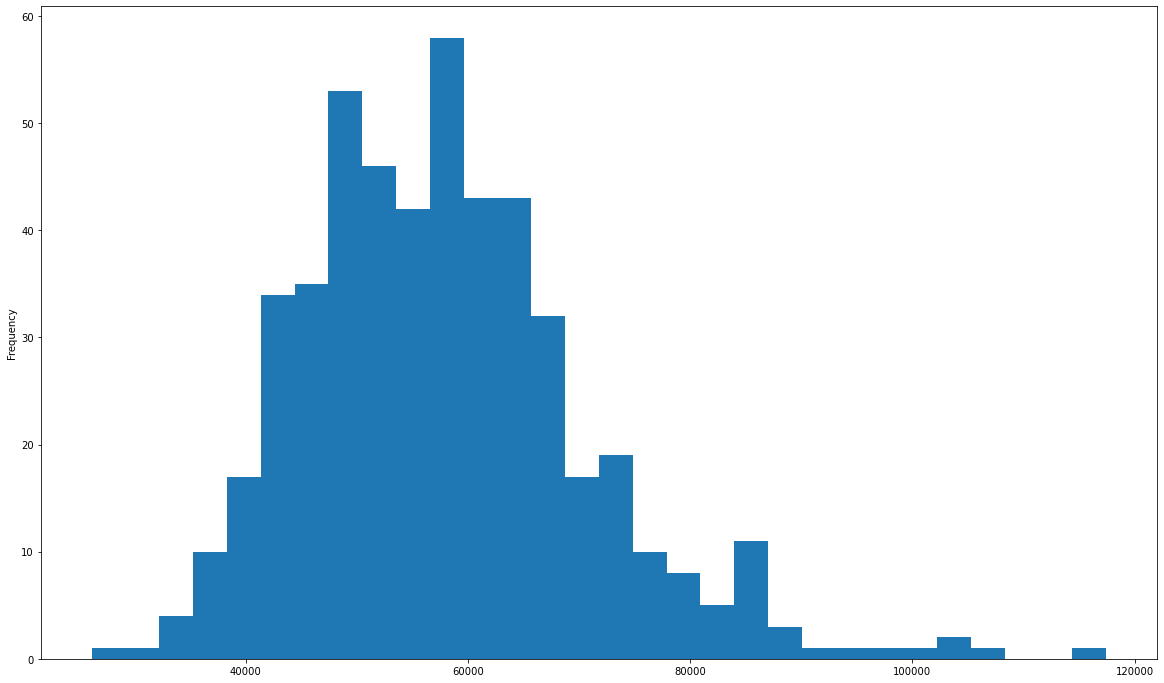

In [32]:
# Plots distribution of ending results.
ending_values.plot.hist(bins = 30, figsize = (20,12), legend=None)

In [33]:
# See summary statistics for ending results
ending_values.describe()

,Ending Values
count,500.000000
mean,57909.830475
std,12838.062365
min,26128.824032
25%,49026.064557
50%,56814.357115
75%,64770.566645
max,117440.442597
